In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## GANS

- [introduction to GANs](https://wiki.pathmind.com/generative-adversarial-network-gan) 
- [deep conv GANs paper](https://arxiv.org/abs/1511.06434)
- [difusion vs. GANs]("https://arxiv.org/abs/2105.05233")
- [intializing weights]("https://wandb.ai/wandb_fc/tips/reports/How-to-Initialize-Weights-in-PyTorch--VmlldzoxNjcwOTg1")

## First model generating monet from random noise, next will use CycleGAN to change the photos style to monet style

In [1]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader , Dataset
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import glob


In [2]:
print(f" monet: {len(os.listdir('/kaggle/input/gan-getting-started/monet_jpg'))}", 
     f"photos: {len(os.listdir('/kaggle/input/gan-getting-started/photo_jpg'))}")

 monet: 300 photos: 7038


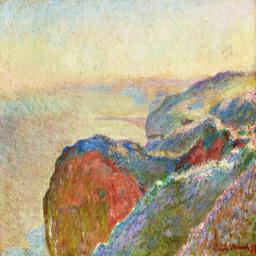

In [3]:
Image.open("/kaggle/input/gan-getting-started/monet_jpg/000c1e3bff.jpg")


In [4]:
np.array(Image.open("/kaggle/input/gan-getting-started/monet_jpg/000c1e3bff.jpg")).shape

(256, 256, 3)

In [5]:
# Discriminator network
class Discriminator(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
        nn.Conv2d(in_channels= in_channel, out_channels= out_channel,
                  kernel_size= (4,4), stride= (2,2), padding= (1,1)), 
            nn.LeakyReLU(0.2),
            self.block(out_channel, 2*out_channel, 4, 2, 1),
            self.block(2*out_channel, 4*out_channel, 4,2,1),
            self.block(4*out_channel, 8*out_channel, 4,2,1),
            nn.Conv2d(8*out_channel, 1 ,4, 2, 0 ),
            nn.Sigmoid()
            
        )
    
    def block( self, in_channel, out_channel, kernel_size, stride, padding):
        return nn.Sequential(
        nn.Conv2d(in_channels= in_channel , out_channels = out_channel,
                 kernel_size= kernel_size ,stride= stride 
                  , padding = padding, bias = False),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, x):
        return self.disc(x)
        
        

In [6]:
class Generator(nn.Module):
    def __init__(self, in_channel, out_channel , output_channel):
        
        super(Generator , self).__init__()
        
        self.Gen = nn.Sequential( self.block(in_channel, out_channel*16, 4,2,0),
                                self.block(out_channel*16, out_channel*8, 4,2,1),
                                self.block(out_channel*8, out_channel*4, 4,2,1),
                                self.block(out_channel*4, out_channel*2, 4,2,1),
                                nn.ConvTranspose2d(out_channel*2 , output_channel, 4,2,1),
                                nn.ReLU(),
                                nn.Tanh()
                                    )
        
        
        
    def block(self, in_channel, out_channel, kernel_size, stride, padding):
        return nn.Sequential(nn.ConvTranspose2d(in_channel, out_channel,
                                                kernel_size , stride, padding, bias = False), 
                             nn.BatchNorm2d(out_channel),# no need for bias while using batchnorm
                            nn.ReLU())
    
    def forward(self, x):
        return self.Gen(x)
    

In [17]:
#intialize weights according to the paper
def weight_intializer(model):
    for module in model.modules():
        if isinstance (module , (nn.ConvTranspose2d , nn.BatchNorm2d , nn.Conv2d)) :
            module.weight.data.normal_(mean = 0.0 , std = 0.02)
            if module.bias is not None:
                module.bias.data.zero_()

In [8]:
def test_dim():
    x = torch.randn(8, 3, 64, 64) # batch_size , color_channels, image_dim
    z = torch.randn(8, 100, 1, 1) # bath_size , noise_dim 
    disc = Discriminator(3 , 8)
    gen = Generator(100, 64 , 3) 
    gen(z).shape
    #gen = Generator(100, 8 , 3)
    
    print(f"dsic output shape {disc(x).shape}", f"gen output shape {gen(z).shape}")

In [9]:
test_dim()

dsic output shape torch.Size([8, 1, 1, 1]) gen output shape torch.Size([8, 3, 64, 64])


## training loop

In [10]:
#hyper parameters
batch_size = 8
learning_rate = 0.0002 #suggested from the paper
img_height = 64
img_width = 64
features_d = 64
features_g = 64
im_channels = 3 # for disc
noise_dim = 100 #in channel for gen
num_epochs = 30
device = "cuda" if torch.cuda.is_available() else "cpu"


In [11]:
transform = transforms.Compose(
[
    transforms.Resize([64 , 64]),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0,0,0], std = [0.5, 0.5, 0.5])
])

In [12]:
class Monet_dataset(Dataset):
    def __init__(self, root , transform = None):
        self.root = root
        self.images = glob.glob("/kaggle/input/gan-getting-started/monet_jpg/*jpg")
        self.transfrom = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img = Image.open(self.images[index])
        if self.transfrom is not None:
            img = self.transfrom(img)
        
        return img
        

In [13]:
train_dataset = Monet_dataset("/kaggle/input/gan-getting-started/monet_jpg", transform = transform)
train_loader = DataLoader(train_dataset , batch_size = batch_size, shuffle = True)

In [18]:
disc = Discriminator(im_channels , features_d).to(device)
gen = Generator(noise_dim ,features_g , im_channels).to(device)
weight_intializer(disc)
weight_intializer(gen)

In [19]:
random_noise = torch.randn(1, noise_dim, 1, 1)

In [20]:
opt_disc = torch.optim.Adam(disc.parameters(),
                                  lr = learning_rate , betas=(0.5, 0.999)) 
#betas values are suggested from the paper
opt_gen = torch.optim.Adam(gen.parameters(),
                                 lr = learning_rate, betas=(0.5, 0.999))
loss_fn = nn.BCELoss()


In [22]:
for epoch in range(num_epochs):
    for indx, (real) in enumerate(iter(train_loader)):
        real = real.to(device)
        noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
        fake = gen(noise)
        # train disc max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = loss_fn(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = loss_fn(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = loss_fn(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if indx % 10 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {indx}/{len(train_loader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )


Epoch [0/30] Batch 0/38                   Loss D: 0.2066, loss G: 2.1313
Epoch [0/30] Batch 10/38                   Loss D: 0.0979, loss G: 2.6699
Epoch [0/30] Batch 20/38                   Loss D: 0.0534, loss G: 3.3389
Epoch [0/30] Batch 30/38                   Loss D: 1.1447, loss G: 2.4487
Epoch [1/30] Batch 0/38                   Loss D: 0.6080, loss G: 1.0539
Epoch [1/30] Batch 10/38                   Loss D: 0.1580, loss G: 2.6107
Epoch [1/30] Batch 20/38                   Loss D: 0.0818, loss G: 3.2422
Epoch [1/30] Batch 30/38                   Loss D: 0.6479, loss G: 0.8665
Epoch [2/30] Batch 0/38                   Loss D: 0.5364, loss G: 1.0040
Epoch [2/30] Batch 10/38                   Loss D: 0.5459, loss G: 1.0483
Epoch [2/30] Batch 20/38                   Loss D: 0.4989, loss G: 1.5074
Epoch [2/30] Batch 30/38                   Loss D: 0.9984, loss G: 3.5821
Epoch [3/30] Batch 0/38                   Loss D: 0.4953, loss G: 1.3833
Epoch [3/30] Batch 10/38                  

torch.Size([1, 3, 64, 64])


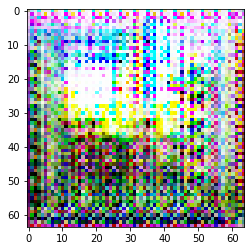

In [26]:
random_noise = torch.randn(100, 1, 1)
with torch.no_grad():
    gen.eval()
    x = gen(random_noise.unsqueeze(0).to(device))
    print(x.shape)
    plt.imshow(np.transpose(x.squeeze(0).to("cpu").numpy(), (1,2,0)))

- the reslts are still nothing near monet pictures, we can try to make further improvments on the model, like going deeper in the architucture, train for more epochs, using data augmentation and regulization. 

